# Burstiness Statistical Deep Dive (CV & Autocorrelation)

This notebook performs a focused *deep dive* analysis on **statistical burstiness features** for
the binary classification problem:

- **HGMG**: Human-generated, Mixtral-graded (Reuters-50/50 subset)
- **LGMG**: LLaMA-generated, Mixtral-graded (same prompt set), scored by Mixtral

We concentrate on two families of features:

1. **Coefficient of variation (CV)** of token-level log-probabilities over rolling windows.
2. **Autocorrelation (ACF)** features summarizing temporal dependence in the log-probability series.

For each family, we:

- Build a feature-only dataframe (CV-only, ACF-only).
- Perform a **threshold search** per feature (1D classifier per feature).
- Train and evaluate a **Random Forest classifier** using only that feature family.

All data loading conventions and paths follow `Burstiness-AllReuters-v2.ipynb`.


In [6]:
import os, glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import pywt
from fingerprinting_llms.score import LogProbs

HUMAN_ROOT_LLAMA    = 'data/tokens/human_llama-graded/reuter5050/C50train_clean'
HUMAN_ROOT_MIXTRAL  = 'data/tokens/human_bigmixtral-graded/reuter5050/C50train_clean'
LLM_ROOT_LLAMA      = 'data/tokens/llama70Bw4a16/reuter5050/C50train_clean'
LLM_ROOT_MIXTRAL    = 'data/tokens/llama70Bw4a16-bigmixtral-graded/reuter5050/C50train_clean'

RNG = np.random.default_rng(42)


## Data Loading Helpers

In [7]:
def find_all_npz(root_dir: str) -> list[str]:
    return sorted(glob.glob(os.path.join(root_dir, '**', '*.npz'), recursive=True))

def load_logp_series_from_root(root_dir: str) -> list[np.ndarray]:
    paths = find_all_npz(root_dir)
    series = []
    for p in paths:
        if LogProbs is not None:
            lp = LogProbs.from_file(p)
            probs = np.asarray(lp.token_probs, dtype=np.float64)
        else:
            with np.load(p, allow_pickle=True) as npzfile:
                if 'token_probs' not in npzfile:
                    continue
                probs = np.asarray(npzfile['token_probs'], dtype=np.float64)

        series.append(probs)
    return series


## Rolling Window Utility

In [8]:
def rolling_windows(a: np.ndarray, window: int, step: int = 1) -> np.ndarray:
    if window < 2 or a.size < window:
        return np.empty((0, window), dtype=a.dtype)
    n = 1 + (a.size - window) // step
    shape = (n, window)
    strides = (a.strides[0]*step, a.strides[0])
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


## Coefficient of Variation (CV) Features

In [9]:
def windowed_cv_features(x: np.ndarray,
                         window_sizes=(4,8,16,32,64,128,256),
                         step_fraction=0.25) -> dict[str, float]:
    """Compute distributional CV stats over rolling windows for each window size.

    For each window size W, we compute the coefficient of variation (CV) over
    rolling windows and then summarize the CV distribution with:
    - mean
    - standard deviation
    - skewness
    - 25th percentile
    - 75th percentile
    - interquartile range (IQR = p75 - p25)
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)
    from scipy.stats import skew

    for w in window_sizes:
        step = max(1, int(w * step_fraction))
        rw = rolling_windows(x, w, step=step)
        if rw.size == 0:
            feats[f'cv_local_mean_w{w}'] = np.nan
            feats[f'cv_local_std_w{w}']  = np.nan
            feats[f'cv_local_skew_w{w}'] = np.nan
            feats[f'cv_local_p25_w{w}']  = np.nan
            feats[f'cv_local_p75_w{w}']  = np.nan
            feats[f'cv_local_iqr_w{w}']  = np.nan
            continue
        mu = rw.mean(axis=1)
        sd = rw.std(axis=1, ddof=1)
        denom = np.maximum(np.abs(mu), 1e-8)
        cv = sd / denom

        # Compute distributional stats on valid CVs
        cv = cv[np.isfinite(cv)]
        if cv.size == 0:
            feats[f'cv_local_mean_w{w}'] = np.nan
            feats[f'cv_local_std_w{w}']  = np.nan
            feats[f'cv_local_skew_w{w}'] = np.nan
            feats[f'cv_local_p25_w{w}']  = np.nan
            feats[f'cv_local_p75_w{w}']  = np.nan
            feats[f'cv_local_iqr_w{w}']  = np.nan
            continue

        feats[f'cv_local_mean_w{w}'] = float(np.nanmean(cv))
        feats[f'cv_local_std_w{w}']  = float(np.nanstd(cv, ddof=1))
        feats[f'cv_local_skew_w{w}'] = float(skew(cv, bias=False, nan_policy='omit'))
        p25 = float(np.nanpercentile(cv, 25))
        p75 = float(np.nanpercentile(cv, 75))
        feats[f'cv_local_p25_w{w}']  = p25
        feats[f'cv_local_p75_w{w}']  = p75
        feats[f'cv_local_iqr_w{w}']  = p75 - p25

    return feats


## Autocorrelation (ACF) Features

We construct a small family of ACF-based summary features from the centered
log-probability sequence. For a maximum lag `L`, we compute the normalized
autocorrelation function `acf[k]` for lags `k = 0..L`, then derive:

- `acf_abs_sum_L{L}`: sum of |acf[k]| for k=1..L
- `acf_lag{lag}`: raw ACF value at specific lags (1, 2, 4, 8, 16, 32)


In [10]:
import numpy as np

def autocorr_1d(x: np.ndarray, max_lag: int) -> np.ndarray:
    """Compute normalized autocorrelation up to max_lag for a 1D array.

    Returns an array acf[0..max_lag] with acf[0] = 1.0.
    """
    x = np.asarray(x, dtype=np.float64)
    if x.size < 2:
        return np.ones(min(max_lag+1, x.size), dtype=np.float64)
    x = x - x.mean()
    n = x.size
    # full autocorrelation, then take non-negative lags
    corr = np.correlate(x, x, mode='full')
    mid = corr.size // 2
    corr_pos = corr[mid:mid+max_lag+1]
    # normalize by variance * n to get acf[0] = 1
    denom = corr_pos[0] if corr_pos[0] != 0 else 1.0
    acf = corr_pos / denom
    return acf

def acf_feature_dict(x: np.ndarray,
                     max_lag: int = 64,
                     summary_lags=(1,2,4,8,16,32)) -> dict[str, float]:
    """Build a dictionary of ACF-based summary features.

    - acf_abs_sum_L{max_lag}: sum of absolute ACF values over lags 1..max_lag
    - acf_lag{lag}: ACF value at a few selected lags (if available)
    """
    feats: dict[str, float] = {}
    x = np.asarray(x, dtype=np.float64)
    if x.size < 3:
        # Too short to be informative; fallback to zeros
        feats[f'acf_abs_sum_L{max_lag}'] = 0.0
        for lag in summary_lags:
            feats[f'acf_lag{lag}'] = 0.0
        return feats

    acf = autocorr_1d(x, max_lag=max_lag)
    # sum of abs ACF over non-zero lags
    if acf.size > 1:
        feats[f'acf_abs_sum_L{max_lag}'] = float(np.sum(np.abs(acf[1:])))
    else:
        feats[f'acf_abs_sum_L{max_lag}'] = 0.0

    for lag in summary_lags:
        if lag < acf.size:
            feats[f'acf_lag{lag}'] = float(acf[lag])
        else:
            feats[f'acf_lag{lag}'] = 0.0

    return feats


## CV + ACF Feature Extractor (Stats-Only)

For this deep dive, we restrict ourselves to **CV** and **ACF** features only
(no Fourier, no wavelets). This keeps the focus on purely statistical burstiness
in the token-level log-probability signal.


In [11]:
def extract_stats_features_from_logp(x: np.ndarray) -> dict[str, float]:
    """Extract CV and ACF features from a 1D log-probability array."""
    x = np.asarray(x, dtype=np.float64)
    feats: dict[str, float] = {}
    # CV features over multiple window sizes
    feats.update(windowed_cv_features(x, window_sizes=(4,8,16,32,64,128,256), step_fraction=0.25))
    # ACF features
    feats.update(acf_feature_dict(x, max_lag=64, summary_lags=(1,2,4,8,16,32)))
    return feats


## Build Stats-Only Feature DataFrame (HGMG vs LGMG)

We now build a dataframe of CV+ACF features for:

- Human-generated, Mixtral-graded (HGMG) documents from `HUMAN_ROOT_MIXTRAL`
- LLaMA-generated, Mixtral-graded (LGMG) documents from `LLM_ROOT_MIXTRAL`


In [12]:
def build_stats_feature_df(human_root: str, llm_root: str) -> pd.DataFrame:
    human_series = load_logp_series_from_root(human_root)
    llm_series   = load_logp_series_from_root(llm_root)

    rows = []
    for idx, seq in enumerate(human_series):
        feats = extract_stats_features_from_logp(seq)
        feats['label'] = 'human'
        feats['doc_id'] = f'human_{idx}'
        rows.append(feats)

    for idx, seq in enumerate(llm_series):
        feats = extract_stats_features_from_logp(seq)
        feats['label'] = 'llm'
        feats['doc_id'] = f'llm_{idx}'
        rows.append(feats)

    df = pd.DataFrame(rows)
    return df.reset_index(drop=True)

# Build the core dataframe for HGMG vs LGMG
df_stats_mixtral = build_stats_feature_df(HUMAN_ROOT_MIXTRAL, LLM_ROOT_MIXTRAL)
df_stats_mixtral.head()


/opt/anaconda3/envs/llm-fp/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,cv_local_mean_w4,cv_local_std_w4,cv_local_skew_w4,cv_local_p25_w4,cv_local_p75_w4,cv_local_iqr_w4,cv_local_mean_w8,cv_local_std_w8,cv_local_skew_w8,cv_local_p25_w8,...,cv_local_iqr_w256,acf_abs_sum_L64,acf_lag1,acf_lag2,acf_lag4,acf_lag8,acf_lag16,acf_lag32,label,doc_id
0,1.022130,0.410486,0.391814,0.711726,1.276573,0.564847,1.082469,0.383917,1.070915,0.807228,...,0.010444,2.157909,0.060229,0.080990,0.033397,0.039333,0.036462,-0.007256,human,human_0
1,1.055492,0.404140,0.361517,0.756933,1.288045,0.531112,1.126115,0.350278,0.809765,0.892783,...,0.127761,1.941472,0.060862,0.048408,0.016597,-0.018011,-0.013159,0.041128,human,human_1
2,1.127067,0.437278,0.453833,0.799084,1.420215,0.621130,1.194014,0.504186,1.547719,0.893756,...,NaN,3.448881,0.003703,-0.076837,0.106432,0.038264,0.019325,-0.035609,human,human_2
3,1.085013,0.396595,0.260145,0.812683,1.307694,0.495011,1.160831,0.350325,0.567842,0.916717,...,0.030083,1.937516,0.020822,0.050922,-0.043807,0.010664,0.047481,-0.035053,human,human_3
4,1.101499,0.402173,0.260420,0.811000,1.342352,0.531352,1.192439,0.345343,0.497020,0.962885,...,0.048455,2.125926,0.028085,0.036134,-0.016538,0.026427,0.116802,0.011299,human,human_4


## Train / Validation Split

In [13]:
def stratified_train_val_split(df_in: pd.DataFrame, test_size: float = 0.2, seed: int = 42):
    y = (df_in['label'] == 'human').astype(int).values
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    (train_idx, val_idx) = next(splitter.split(df_in, y))
    train_df = df_in.iloc[train_idx].reset_index(drop=True)
    val_df   = df_in.iloc[val_idx].reset_index(drop=True)
    return train_df, val_df


## Per-Feature Threshold Search Utilities

For each scalar feature, we search over candidate thresholds and directions
(`>=` vs `<=`) on the **training** set to maximize macro-F₁, then evaluate that
single-threshold classifier on both train and validation splits.


In [14]:
from dataclasses import dataclass
from typing import List, Tuple, Dict

@dataclass
class ThresholdResult:
    feature: str
    direction: str
    threshold: float
    degenerate: bool
    train_accuracy: float
    train_precision: float
    train_recall: float
    train_f1_macro: float
    train_auroc: float
    val_accuracy: float
    val_precision: float
    val_recall: float
    val_f1_macro: float
    val_auroc: float

def _eval_threshold(y_true: np.ndarray,
                    scores: np.ndarray,
                    threshold: float,
                    direction: str,
                    positive_label: int = 1) -> Tuple[np.ndarray, Dict[str,float]]:
    """Apply a single threshold to scores and compute metrics."""
    if direction == '>=':
        y_pred = (scores >= threshold).astype(int)
    else:
        y_pred = (scores <= threshold).astype(int)

    degenerate = (y_pred.min() == y_pred.max())
    metrics = {}
    metrics['degenerate'] = degenerate
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        metrics['auroc'] = roc_auc_score(y_true, scores)
    except Exception:
        metrics['auroc'] = np.nan
    return y_pred, metrics

def threshold_search_for_feature(train_df: pd.DataFrame,
                                 val_df: pd.DataFrame,
                                 feature: str,
                                 positive_label: str = 'human',
                                 n_grid: int = 200) -> ThresholdResult:
    """Find the best 1D threshold classifier for a given feature.

    The positive class is mapped from `positive_label`. We search over
    `>=` and `<=` directions and a grid of thresholds spanning the feature
    range in the training set.
    """
    # Encode labels as 0/1
    y_train = (train_df['label'] == positive_label).astype(int).values
    y_val   = (val_df['label'] == positive_label).astype(int).values

    x_train = train_df[feature].values.astype(float)
    x_val   = val_df[feature].values.astype(float)

    finite_mask = np.isfinite(x_train)
    x_train = x_train[finite_mask]
    y_train_nonan = y_train[finite_mask]
    if x_train.size == 0:
        return ThresholdResult(feature, '>=', np.nan, True,
                               np.nan, np.nan, np.nan, np.nan, np.nan,
                               np.nan, np.nan, np.nan, np.nan, np.nan)

    lo, hi = np.nanmin(x_train), np.nanmax(x_train)
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = lo, lo + 1e-6

    grid = np.linspace(lo, hi, n_grid)
    best_res = None
    best_score = -1.0

    for direction in ('>=','<='):
        for t in grid:
            _, m_train = _eval_threshold(y_train_nonan, x_train, t, direction)
            if m_train['f1_macro'] > best_score:
                best_score = m_train['f1_macro']
                best_res = (t, direction, m_train)

    # Recompute metrics on full train and validation with best threshold
    best_t, best_dir, train_metrics = best_res
    _, train_metrics_full = _eval_threshold(y_train, train_df[feature].values.astype(float), best_t, best_dir)
    _, val_metrics = _eval_threshold(y_val, val_df[feature].values.astype(float), best_t, best_dir)

    return ThresholdResult(
        feature=feature,
        direction=best_dir,
        threshold=float(best_t),
        degenerate=train_metrics_full['degenerate'],
        train_accuracy=train_metrics_full['accuracy'],
        train_precision=train_metrics_full['precision_macro'],
        train_recall=train_metrics_full['recall_macro'],
        train_f1_macro=train_metrics_full['f1_macro'],
        train_auroc=train_metrics_full['auroc'],
        val_accuracy=val_metrics['accuracy'],
        val_precision=val_metrics['precision_macro'],
        val_recall=val_metrics['recall_macro'],
        val_f1_macro=val_metrics['f1_macro'],
        val_auroc=val_metrics['auroc'],
    )


## CV Deep Dive: Threshold Search and Random Forest

We now isolate **CV features** (`cv_local_mean_w*`) and:

1. Run a per-feature threshold search.
2. Train a Random Forest classifier using only these CV features.


In [15]:
# Split train/validation
train_stats, val_stats = stratified_train_val_split(df_stats_mixtral, test_size=0.2, seed=42)

# Identify CV feature columns (all CV-related stats)
cv_features = [c for c in df_stats_mixtral.columns if c.startswith('cv_local_')]

# Run threshold search for each CV feature
cv_results = []
for feat in cv_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    cv_results.append(res.__dict__)

cv_results_df = pd.DataFrame(cv_results).sort_values('val_f1_macro', ascending=False)
cv_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_macro,val_auroc
24,cv_local_mean_w64,<=,1.302008,False,0.802482,0.762433,0.746554,0.753507,NaN,0.786119,0.741513,0.729117,0.734623,NaN
36,cv_local_mean_w256,<=,1.318706,False,0.806738,0.769135,0.747043,0.756292,NaN,0.786119,0.741641,0.727689,0.733796,NaN
30,cv_local_mean_w128,<=,1.313531,False,0.808156,0.770588,0.750197,0.758863,NaN,0.784703,0.739762,0.726689,0.732450,NaN
39,cv_local_p25_w256,<=,1.298938,False,0.804610,0.778507,0.719344,0.737861,NaN,0.793201,0.759954,0.708427,0.724787,NaN
18,cv_local_mean_w32,<=,1.294225,False,0.801064,0.761557,0.740529,0.749341,NaN,0.780453,0.734891,0.715126,0.723239,NaN
34,cv_local_p75_w128,<=,1.399338,False,0.799645,0.763372,0.727326,0.740647,NaN,0.784703,0.743716,0.706709,0.719692,NaN
28,cv_local_p75_w64,<=,1.410395,False,0.786170,0.742989,0.716745,0.726984,NaN,0.781870,0.738862,0.706136,0.717996,NaN
40,cv_local_p75_w256,<=,1.383200,False,0.795745,0.760755,0.715962,0.731183,NaN,0.781870,0.738862,0.706136,0.717996,NaN
33,cv_local_p25_w128,<=,1.234493,False,0.780851,0.734728,0.718017,0.725095,NaN,0.771955,0.723455,0.710553,0.716166,NaN
22,cv_local_p75_w32,<=,1.461133,False,0.804255,0.785721,0.709762,0.730672,NaN,0.796034,0.777921,0.694728,0.715275,NaN


Mixtral-graded (HGMG vs LGMG) : CV-only Random Forest
accuracy (val):        0.807
precision_macro (val): 0.780
recall_macro (val):    0.727
f1_macro (val):        0.745
AUROC (val):           0.861


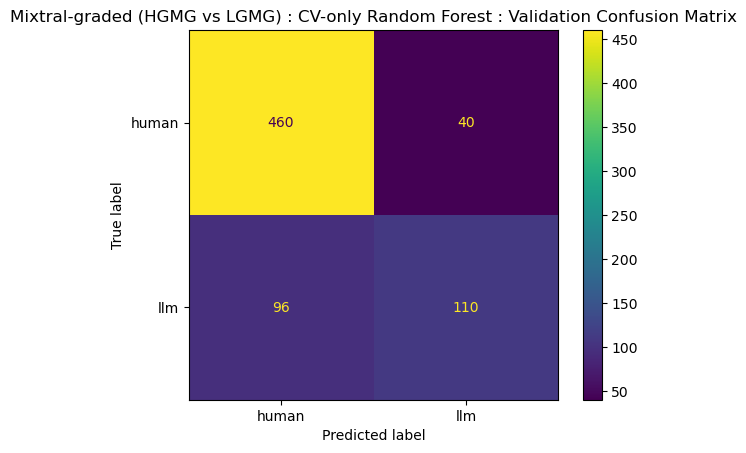

cv_local_mean_w64     0.066884
cv_local_mean_w32     0.061344
cv_local_mean_w128    0.060402
cv_local_mean_w256    0.045802
cv_local_mean_w16     0.039294
cv_local_p75_w16      0.038549
cv_local_p25_w256     0.032441
cv_local_p75_w64      0.030347
cv_local_p75_w32      0.029849
cv_local_mean_w4      0.028203
cv_local_p75_w4       0.026260
cv_local_mean_w8      0.026217
cv_local_p75_w128     0.025369
cv_local_std_w64      0.024479
cv_local_std_w32      0.022341
cv_local_skew_w64     0.021650
cv_local_p25_w128     0.020683
cv_local_p75_w8       0.019912
cv_local_p75_w256     0.019215
cv_local_skew_w256    0.019087
dtype: float64

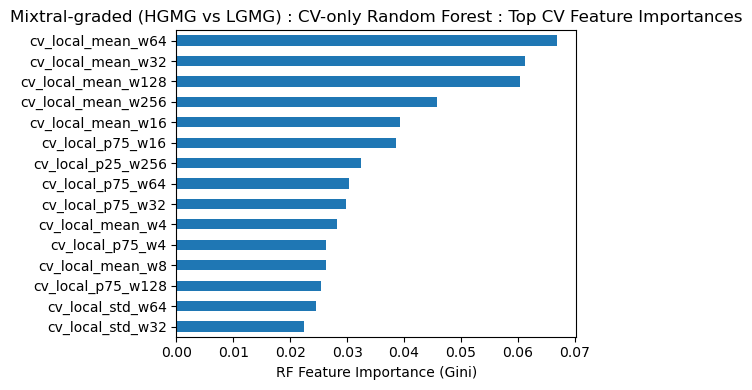

In [16]:
def model_eval_random_forest_subset(train_df: pd.DataFrame,
                                      val_df: pd.DataFrame,
                                      feature_cols: list[str],
                                      title: str = ""):
    # Prepare design matrices
    X_train = train_df[feature_cols].copy().fillna(train_df[feature_cols].mean())
    X_val   = val_df[feature_cols].copy().fillna(train_df[feature_cols].mean())

    le = LabelEncoder()
    le.fit(train_df['label'])
    y_train = le.transform(train_df['label'])
    y_val   = le.transform(val_df['label'])

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    y_val_proba = rf.predict_proba(X_val)[:, 1]

    acc  = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='macro', zero_division=0)
    rec  = recall_score(y_val, y_val_pred, average='macro', zero_division=0)
    f1m  = f1_score(y_val, y_val_pred, average='macro', zero_division=0)
    auroc = roc_auc_score(y_val, y_val_proba)

    print(f"{title}")
    print("="*len(title))
    print(f"accuracy (val):        {acc:.3f}")
    print(f"precision_macro (val): {prec:.3f}")
    print(f"recall_macro (val):    {rec:.3f}")
    print(f"f1_macro (val):        {f1m:.3f}")
    print(f"AUROC (val):           {auroc:.3f}")

    cm = confusion_matrix(y_val, y_val_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.inverse_transform([0,1]))
    disp.plot(values_format='d')
    plt.title(f'{title} : Validation Confusion Matrix')
    plt.show()

    importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(importances.head(20))
    plt.figure(figsize=(6,4))
    importances.head(15).plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.xlabel('RF Feature Importance (Gini)')
    plt.title(f'{title} : Top CV Feature Importances')
    plt.tight_layout()
    plt.show()

    return {
        'model': rf,
        'feature_cols': feature_cols,
        'label_encoder': le,
        'val_predictions': y_val_pred,
        'val_truth': y_val,
        'val_proba': y_val_proba,
        'val_feature_importances': importances,
    }

# Run RF on CV features only
cv_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=cv_features,
    title='Mixtral-graded (HGMG vs LGMG) : CV-only Random Forest'
)


## ACF Deep Dive: Threshold Search and Random Forest

Now we repeat the same procedure using **ACF-based features** only.


In [19]:
# Identify ACF feature columns
acf_features = [c for c in df_stats_mixtral.columns if c.startswith('acf_')]

# Threshold search per ACF feature
acf_results = []
for feat in acf_features:
    res = threshold_search_for_feature(train_stats, val_stats, feature=feat, positive_label='human', n_grid=200)
    acf_results.append(res.__dict__)

acf_results_df = pd.DataFrame(acf_results).sort_values('val_f1_macro', ascending=False)
acf_results_df


,feature,direction,threshold,degenerate,train_accuracy,train_precision,train_recall,train_f1_macro,train_auroc,val_accuracy,val_precision,val_recall,val_f1_macro,val_auroc
0,acf_abs_sum_L64,<=,2.367879,False,0.789362,0.755778,0.699616,0.716449,0.210926,0.773371,0.726036,0.701563,0.710990,0.192408
3,acf_lag4,<=,0.044847,False,0.690071,0.626725,0.628863,0.627730,0.347107,0.702550,0.637666,0.634437,0.635932,0.339350
2,acf_lag2,<=,0.058615,False,0.718440,0.654707,0.646720,0.650137,0.310934,0.699717,0.635431,0.633864,0.634618,0.324728
1,acf_lag1,<=,0.097646,False,0.706028,0.625092,0.594899,0.600174,0.373777,0.713881,0.638408,0.605330,0.611826,0.341903
4,acf_lag8,<=,0.040005,False,0.684043,0.614492,0.612050,0.613178,0.374459,0.671388,0.594769,0.589602,0.591635,0.361583
5,acf_lag16,<=,0.035777,False,0.668440,0.592966,0.589560,0.591011,0.395794,0.655807,0.587832,0.590019,0.588798,0.399748
6,acf_lag32,<=,0.044716,False,0.696099,0.604345,0.572822,0.574619,0.416065,0.671388,0.556158,0.536796,0.531273,0.463641


Mixtral-graded (HGMG vs LGMG) : ACF-only Random Forest
accuracy (val):        0.792
precision_macro (val): 0.760
recall_macro (val):    0.703
f1_macro (val):        0.720
AUROC (val):           0.803


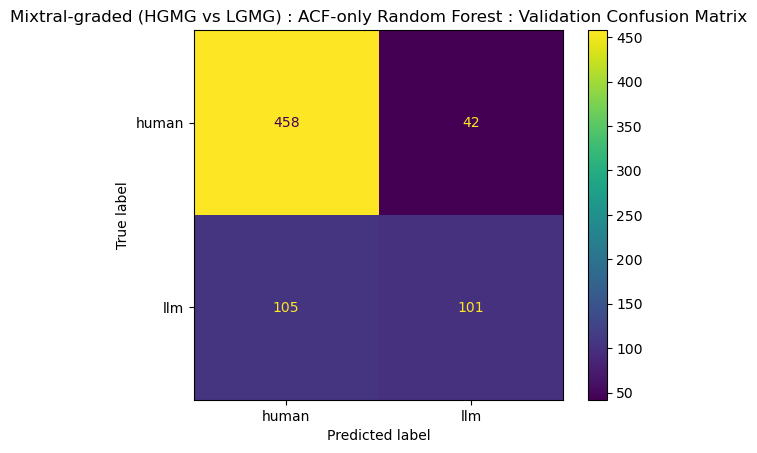

acf_abs_sum_L64    0.281217
acf_lag2           0.162240
acf_lag4           0.125865
acf_lag8           0.121562
acf_lag16          0.106098
acf_lag32          0.103590
acf_lag1           0.099428
dtype: float64

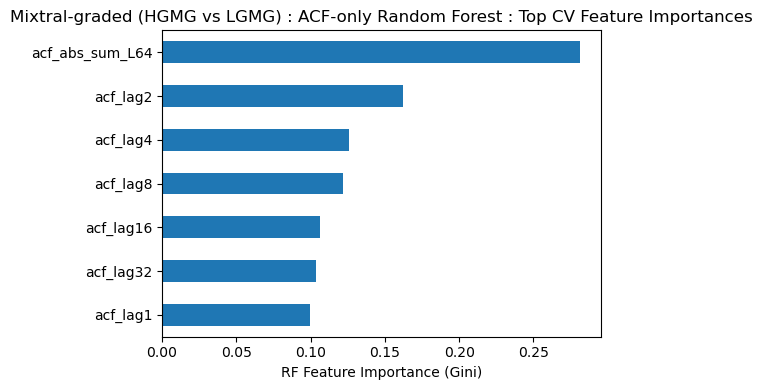

In [20]:
# RF on ACF features only
acf_rf_results = model_eval_random_forest_subset(
    train_stats, val_stats, feature_cols=acf_features,
    title='Mixtral-graded (HGMG vs LGMG) : ACF-only Random Forest'
)


## RESULTS
We do not see any significant improvement in detection performance when using only CV or ACF features compared to our full feature set as explored in Burstiness-AllAuthors-v2.ipynb.  Future exploration will focus on more signal-oriented features as well as "event-based" analysis.